In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
  query: str
  answer: str #세율
  tax_base_equation : str #과세표준 계산 수식
  tax_deduction : str #공제액
  market_ratio : str #공정시장가액비율
  tax_base: str #과세표준 계산
  #세율계산

graph_builder = StateGraph(AgentState)

In [6]:

from pinecone import Pinecone
from langchain_openai import OpenAIEmbeddings
import dotenv 
from langchain_pinecone import PineconeVectorStore


dotenv.load_dotenv()
index_name = "real-estate-tax"
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')
vectorstore = PineconeVectorStore(index_name=index_name, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={'k':4})


C:\Users\soobi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
from langchain_openai import ChatOpenAI
from langsmith import Client
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

client = Client()
rag_prompt = client.pull_prompt("rlm/rag-prompt")

llm = ChatOpenAI(model='gpt-4o', temperature=0.2)



In [46]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을때 세금을 얼마나 내나요?'

In [26]:
tax_base_retrieval_chain = {'context': retriever, 'question': RunnablePassthrough()} | rag_prompt | llm | StrOutputParser()

tax_base_equation_prompt = ChatPromptTemplate.from_messages(

    [
        ("system", "당신은 종합부동산세 계산 전문가입니다. 아래 문서들을 참고하여 주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 알려주세요. 부연설명 없이 수식만 리턴하세요"),
        ("human", "{tax_base_equation_information}")
    ]
)

tax_base_equation_chain = (

   {'tax_base_equation_information': RunnablePassthrough()}
   | tax_base_equation_prompt 
   | llm
   | StrOutputParser()

)

tax_base_chain = {'tax_base_equation_information' : tax_base_retrieval_chain} | tax_base_equation_chain





def get_tax_equation(state :AgentState) -> str:
    # 1. 벡터 검색을 통해 관련 문서 가져오기
   tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 알려주세요.'
   tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
  
   return {'tax_base_equation': tax_base_equation}


In [27]:
get_tax_equation({})

{'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율'}

In [28]:

tax_deduction_chain = (

   {'context': retriever, 'question': RunnablePassthrough()}
   | rag_prompt 
   | llm
   | StrOutputParser()

)


def get_tax_deduction(state :AgentState) -> str:
    # 1. 벡터 검색을 통해 관련 문서 가져오기
   tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요.'
   tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
  
   return {'tax_deduction': tax_deduction}

In [29]:
get_tax_deduction({})

{'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원이며, 그 외의 경우에는 9억 원입니다.'}

In [35]:
from langchain_tavily import TavilySearch
from datetime import date

tool = TavilySearch(
    max_results=5,
    topic="general",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
   
)


tax_market_ration_prompt = ChatPromptTemplate.from_messages(    

    [
        ("system", "당신은 종합부동산세 계산 전문가입니다. 아래 검색 결과를 참고하여 주택에 대한 종합부동산세 계산시 공시가격의 공정시장가액비율을 알려주세요.\n\nContext: \n{context} "),
        ("human", "{query}")
    ]
)

def tax_market_ratio(state: AgentState) -> str:
    query = '오늘날짜: ({date.today()})에 주택 공시가격 공정시장가액비율'
    context = tool.invoke(query)

    tax_market_ratio_chain = (
        
        tax_market_ration_prompt
        | llm
        | StrOutputParser()
    )       

    tax_market_ratio = tax_market_ratio_chain.invoke({'context' :context , 'query': query})
    return {'market_ratio': tax_market_ratio}

    

In [36]:
tax_market_ratio({})

{'market_ratio': '현재 주택 공시가격의 공정시장가액비율은 60%입니다. 2023년부터는 공시가격 구간별로 43%, 44%, 45%로 차등 적용되었습니다.'}

In [42]:
pip install langchain_core

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\soobi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [45]:
from langchain_core.prompts import PromptTemplate

tax_base_calculation_prompt = PromptTemplate.from_template("""

주어진 내용을 기반으로 과세표준을 계산해주세요.

과세표준 계산 공식 : {tax_base_equation}
공제액 : {tax_deduction}
공정시장가액비율 : {market_ratio}
사용자 주택 공시가격 정보: {query}                                                                                                           


""")




def calculate_tax_base(state: AgentState) -> str:
    # 과세표준 계산 수식과 공제액, 공정시장가액비율을 이용하여 과세표준 계산
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
   
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })
    
    return {'tax_base': tax_base}

In [47]:
initial_state = {
        'query': query,
        'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율',
        'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원이며, 그 외의 경우에는 9억 원입니다.',
        'market_ratio': '현재 주택 공시가격의 공정시장가액비율은 60%입니다.',
        
    
}

In [48]:
calculate_tax_base(initial_state)

{'tax_base': '주어진 정보를 바탕으로 과세표준을 계산해보겠습니다.\n\n1. **주택의 공시가격 합계**:\n   - 5억 원짜리 집 1채\n   - 10억 원짜리 집 1채\n   - 20억 원짜리 집 1채\n\n   총 공시가격 합계 = 5억 + 10억 + 20억 = 35억 원\n\n2. **공제금액**:\n   - 1세대 1주택자가 아닌 경우, 공제금액은 9억 원입니다.\n\n3. **공정시장가액비율**:\n   - 현재 주택 공시가격의 공정시장가액비율은 60%입니다.\n\n4. **과세표준 계산**:\n   \\[\n   \\text{과세표준} = (\\text{주택의 공시가격 합계} - \\text{공제금액}) \\times \\text{공정시장가액비율}\n   \\]\n   \\[\n   \\text{과세표준} = (35억 - 9억) \\times 0.6 = 26억 \\times 0.6 = 15.6억 원\n   \\]\n\n따라서, 과세표준은 15.6억 원입니다. 이 과세표준을 바탕으로 종합부동산세가 계산됩니다. 종합부동산세율은 과세표준 구간에 따라 다르므로, 추가적인 세율 정보가 필요합니다.'}

{'tax_base': '주어진 정보를 바탕으로 과세표준을 계산해보겠습니다.\n\n1. **주택의 공시가격 합계**:\n   - 5억 원짜리 집 1채\n   - 10억 원짜리 집 1채\n   - 20억 원짜리 집 1채\n\n   총 공시가격 합계 = 5억 + 10억 + 20억 = 35억 원\n\n2. **공제금액**:\n   - 1세대 1주택자가 아닌 경우, 공제금액은 9억 원입니다.\n\n3. **공정시장가액비율**:\n   - 현재 주택 공시가격의 공정시장가액비율은 60%입니다.\n\n4. **과세표준 계산**:\n   \\[\n   \\text{과세표준} = (\\text{주택의 공시가격 합계} - \\text{공제금액}) \\times \\text{공정시장가액비율}\n   \\]\n   \\[\n   \\text{과세표준} = (35억 - 9억) \\times 0.6 = 26억 \\times 0.6 = 15.6억 원\n   \\]\n\n따라서, 과세표준은 15.6억 원입니다. 이 과세표준을 바탕으로 종합부동산세가 계산됩니다. 종합부동산세율은 과세표준 구간에 따라 다르므로, 추가적인 세율 정보가 필요합니다.'}  

In [75]:


tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ("system", "당신은 종합부동산세 계산 전문가입니다. 아래 검색 결과를 참고하여 주택에 대한 종합부동산세율을 알려주세요.\n\nContext: \n{context} "),
    ("human", '''
과세표준과 사용자가 소지한 주택의수가 아래와 같을때 종합부동산세를 계산해주세요
     
     
     과세표준: {tax_base}
     사용자 주택 정보: {query}''')
])

def calculate_tax_rate(state: AgentState) -> str:
    query = state['query']
    tax_base= state['tax_base']
    context  = retriever.invoke(query)
    tax_rate_calculation_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )

    tax_rate = tax_rate_calculation_chain.invoke({'context': context, 'query': query, 'tax_base': tax_base})
    print((f"Calculated tax rate: {tax_rate}"))
    return {'tax_rate': tax_rate}

In [77]:
calculate_base_state = {'tax_base':'과세표준은 15.6억 원입니다. 이 과세표준을 바탕으로 종합부동산세가 계산됩니다. 종합부동산세율은 과세표준 구간에 따라 다르므로, 추가적인 세율 정보가 필요합니다.', 'query': query}

In [78]:
calculate_tax_rate(calculate_base_state)


Calculated tax rate: 사용자가 소유한 주택의 총 가치는 5억 + 10억 + 20억 = 35억 원입니다. 이 경우, 사용자는 3주택 이상을 소유한 경우에 해당합니다. 따라서 3주택 이상 소유자의 종합부동산세율을 적용해야 합니다.

과세표준이 15.6억 원인 경우, 3주택 이상 소유자의 세율은 다음과 같습니다:

- 12억원 초과 25억원 이하: 960만원 + (12억원을 초과하는 금액의 20)

과세표준이 15.6억 원이므로, 12억 원을 초과하는 금액은 15.6억 - 12억 = 3.6억 원입니다.

따라서, 종합부동산세는 다음과 같이 계산됩니다:

960만원 + (3.6억 원 * 0.002) = 960만원 + 720만원 = 1,680만원

따라서, 사용자는 1,680만원의 종합부동산세를 납부해야 합니다.


{'tax_rate': '사용자가 소유한 주택의 총 가치는 5억 + 10억 + 20억 = 35억 원입니다. 이 경우, 사용자는 3주택 이상을 소유한 경우에 해당합니다. 따라서 3주택 이상 소유자의 종합부동산세율을 적용해야 합니다.\n\n과세표준이 15.6억 원인 경우, 3주택 이상 소유자의 세율은 다음과 같습니다:\n\n- 12억원 초과 25억원 이하: 960만원 + (12억원을 초과하는 금액의 20)\n\n과세표준이 15.6억 원이므로, 12억 원을 초과하는 금액은 15.6억 - 12억 = 3.6억 원입니다.\n\n따라서, 종합부동산세는 다음과 같이 계산됩니다:\n\n960만원 + (3.6억 원 * 0.002) = 960만원 + 720만원 = 1,680만원\n\n따라서, 사용자는 1,680만원의 종합부동산세를 납부해야 합니다.'}

In [79]:
graph_builder.add_node('get_tax_base_equation', get_tax_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('tax_market_ratio', tax_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)



In [80]:
from langgraph.graph import START , END


graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'tax_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('tax_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [81]:
graph = graph_builder.compile()

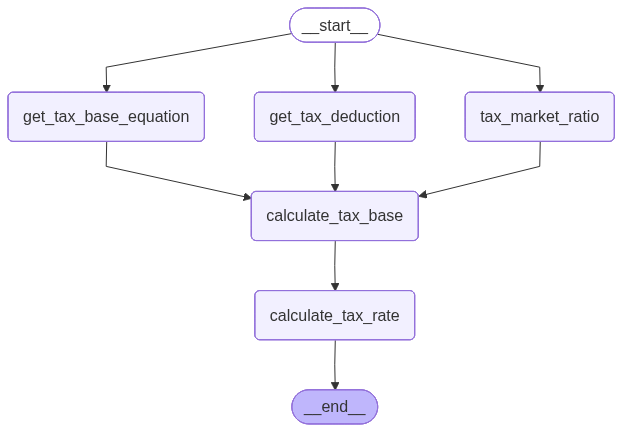

In [82]:
from IPython.display  import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [84]:
inital_state = {'query': query}
graph.invoke(inital_state)

Calculated tax rate: 사용자가 소유한 주택의 총 공시가격은 35억 원이며, 3채의 주택을 소유하고 있으므로, 3주택 이상 소유한 경우의 세율을 적용해야 합니다.

1. **과세표준**: 15.6억 원

2. **세율 적용**:
   - 과세표준이 12억 원 초과 25억 원 이하인 경우, 3주택 이상 소유한 경우의 세율은 다음과 같습니다:
     \[
     960만원 + (12억원을 초과하는 금액의 20)
     \]

3. **세금 계산**:
   - 15.6억 원은 12억 원을 초과하므로, 초과 금액은 3.6억 원입니다.
   - 초과 금액에 대한 세금: \(3.6억 \times 0.002 = 720만원\)
   - 총 세금: \(960만원 + 720만원 = 1,680만원\)

따라서, 사용자는 1,680만원의 종합부동산세를 납부해야 합니다.


{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을때 세금을 얼마나 내나요?',
 'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제 금액) × 공정시장가액비율',
 'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원, 그 외의 경우 9억 원입니다.',
 'market_ratio': '2024년 현재 주택 공시가격 공정시장가액비율은 60%입니다.',
 'tax_base': '주어진 정보를 바탕으로 과세표준을 계산해보겠습니다.\n\n1. **주택의 공시가격 합계**:\n   - 5억 원짜리 집 1채\n   - 10억 원짜리 집 1채\n   - 20억 원짜리 집 1채\n\n   총 공시가격 = 5억 + 10억 + 20억 = 35억 원\n\n2. **공제 금액**:\n   - 1세대 1주택자가 아닌 경우 공제 금액은 9억 원입니다.\n\n3. **공정시장가액비율**:\n   - 2024년 현재 주택 공시가격 공정시장가액비율은 60%입니다.\n\n4. **과세표준 계산**:\n   \\[\n   \\text{과세표준} = (\\text{주택의 공시가격 합계} - \\text{공제 금액}) \\times \\text{공정시장가액비율}\n   \\]\n   \\[\n   \\text{과세표준} = (35억 - 9억) \\times 0.6 = 26억 \\times 0.6 = 15.6억 원\n   \\]\n\n따라서, 과세표준은 15.6억 원입니다. 이 과세표준을 바탕으로 종합부동산세를 계산하게 됩니다. 종합부동산세율은 과세표준에 따라 다르게 적용되므로, 정확한 세금 계산을 위해서는 해당 세율을 확인해야 합니다.'}